#Tarea 2: Arquitecturas modernas de Redes Neuronales profundas - CNN & UNETs
----

Estudiante: Rafael Contreras

CI: 30391915

## 1. Introduccion

### Notebooks libro UDL


Anexados notebooks del libro del libro UDL

### Integrar la pregunta en la seccion Evaluacion

Notebooks 7.2 y 7.3.
Verifique que los resultados obtenidos son los mismos a los del notebook.

### Informe sobre preguntas practicas

link al informe

### Explicacion de notebooks

#### [Notebook 10.1 - 1D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_1_1D_Convolution.ipynb)



#### [Notebook 10.2 - Convolution for MNIST-1D](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_2_Convolution_for_MNIST_1D.ipynb)


#### [Notebook 10.3 - 2D convolution](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_3_2D_Convolution.ipynb)

#### [Notebook 10.4 - Downsampling & upsampling](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_4_Downsampling_and_Upsampling.ipynb)

#### [Notebook 10.5 - Convolution for MNIST](https://github.com/Rcontre360/deep-learning-ucv-2025/blob/main/tarea2/notebooks/10_5_Convolution_For_MNIST.ipynb)

### 1. Experimento

In [231]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [232]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("martininf1n1ty/mnist100")  + '/mnist_compressed.npz'
print(path)

/home/rafael/.cache/kagglehub/datasets/martininf1n1ty/mnist100/versions/1/mnist_compressed.npz


In [233]:
img_size = 128

class NPZTrainDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)

        self.images = data['train_images']
        self.labels = data['train_labels']
        self.transform = transform or transforms.ToPILImage()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)
        image = self.transform(image)

        return image, label

In [234]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [235]:
dataset = NPZTrainDataset(path,train_transforms)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size_train = 64
batch_size_test = 1000

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

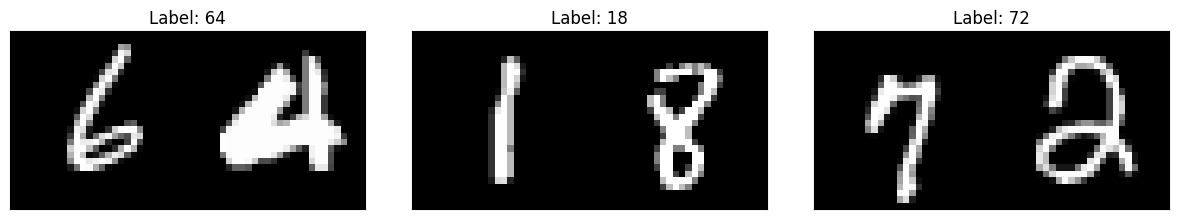

In [236]:
import matplotlib.pyplot as plt

dataset = MNIST100Dataset(path)

fig = plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.tight_layout()

    image, label = dataset[i]

    if hasattr(image, 'numpy'):
        image = image.numpy()

    if len(image.shape) == 3:
        if image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
        if image.shape[2] == 3:
            image = image.mean(axis=2)

    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Label: {}".format(label))
    plt.xticks([])
    plt.yticks([])

plt.show()

In [237]:
# Main training routine
def train(epoch,model,optimizer):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

# Run on test data
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      print("SHAPE",data.shape)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [245]:
class MNIST100Model(nn.Module):
    def __init__(self, img_width,img_height):
        super(MNIST100Model, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(1, 10, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Conv2d(10, 20, kernel_size=5),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(16820,50),
          nn.ReLU(),
          nn.Linear(50,100),
          nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

In [246]:
model = MNIST100Model(img_size,img_size)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:

n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch,model,optimizer)
  test(model)

Train Epoch: 1 [0/48000]	Loss: 4.618168
Train Epoch: 1 [640/48000]	Loss: 4.610519
Train Epoch: 1 [1280/48000]	Loss: 4.603301
Train Epoch: 1 [1920/48000]	Loss: 4.595967
Train Epoch: 1 [2560/48000]	Loss: 4.587293
Train Epoch: 1 [3200/48000]	Loss: 4.585053
Train Epoch: 1 [3840/48000]	Loss: 4.601756


## Evaluacion

### III-A. CNN

#### 1. Considere la siguiente matriz de entrada $X$:


$$
X = \begin{bmatrix}
2 & 5 & 4 & 1 \\
3 & 1 & 2 & 0 \\
4 & 5 & 7 & 1 \\
1 & 2 & 3 & 4
\end{bmatrix}
$$


##### a) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, sin *padding* y con un *stride* de 2.



$$
K = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

RESPUESTA:

$$
\begin{align*}
res_{0,0} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * 1 = 3
\\
res_{0,1} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * 1 = 4
\\
res_{1,0} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * 1 = 6
\\
res_{1,1} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * 1 = 11
\\
\end{align*}
\\\\
Res = \begin{bmatrix}
3 & 4 \\
6 & 11
\end{bmatrix}
$$

##### b) Calcule la salida de una convolución con un kernel $K$ de dimensión $2 \times 2$, con *padding* de 2 y con un *stride* de 2.


$$
K = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

Con un padding de 2 la matriz a la que le realizariamos la convolucion seria:

$$
X = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 2 & 5 & 4 & 1 & 0 & 0 \\
0 & 0 & 3 & 1 & 2 & 0 & 0 & 0 \\
0 & 0 & 4 & 5 & 7 & 1 & 0 & 0 \\
0 & 0 & 1 & 2 & 3 & 4 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$$

$$
\begin{align*}
\begin{array}{ll}
res_{0,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{0,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{0,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{1,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{1,1} &= 2 * 1 + 5 * 0 + 3 * 0 + 1 * (-1) = 1 \\
res_{1,2} &= 4 * 1 + 1 * 0 + 2 * 0 + 0 * (-1) = 4 &
res_{1,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{2,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{2,1} &= 4 * 1 + 5 * 0 + 1 * 0 + 2 * (-1) = 2 \\
res_{2,2} &= 7 * 1 + 1 * 0 + 3 * 0 + 4 * (-1) = 3 &
res_{2,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,0} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,1} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 \\
res_{3,2} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0 &
res_{3,3} &= 0 * 1 + 0 * 0 + 0 * 0 + 0 * (-1) = 0
\end{array}
\end{align*}
$$

$$
\text{Res} = \begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 1 & 4 & 0 \\
0 & 2 & 3 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

#### 2. ¿Cómo podemos determinar la dimensión de salida luego de aplicar la función de convolución?


Esto dependera del kernel size, el padding, el stride y el dilation. El kernel size y el padding determinan cuantos "cuadrantes" tenemos disponibles para el calculo. Con cuadrante me refiero a la region que se operara con el kernel para obtener un elemento de la matriz resultante.

Aumentar el padding incrementa la cantidad de cuadrantes que podemos usar. Aumentar el stride, kernel size o dilation reduce la cantidad de cuadrantes.

Entonces la dimension final vendria dada (en filas y columnas) por:

[Referencia](https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer)

$$
[(matrix\_size−kernel\_size+2*padding)/stride]+1
$$

#### 3. ¿Qué beneficios tiene el uso de Redes Neuronales Convolucionales (CNNs) sobre las redes completamente conectadas?


1 - Se realizan menos operaciones. \\
2 - Mantienen el contexto del valor de cada pixel. Ya que la operacion de convolucion usa los vecinos de un pixel y no todos los valores de la imagen.

### III-B. CNN Segmentation

NOTA: explicar el articulo agregado de segmentacion (redes segmentadas). Explicar metricas para evaluar segmentacion de imagenes
?colocar 2 graficas mas que sean utiles?
mejorar las metricas dice e iou